In [1]:
import sys
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
import plotly.express as px

# vseek imports
sys.path.append("..")
import vseek.common.loader as vloader 
from vseek.common.io_files import save_interaction_profiles


In [2]:
# midway sample data (over 900 minutes of calculations)
# NOTE LOADING DBATVIR data
dbat_vir_df = vloader.load_dbat_vir_db()

# NOTE LOADING NCBI ACCESSION DATA 
ncbi_virus_data = vloader.load_bat_virus_data()

# NOTE: LOADING GEO DATA
geolocations_df = vloader.load_geolocations()
geolocations_df = geolocations_df[["country", "name"]]
geolocations_df.columns = ["iso_alpha", "country"]
iso_codes_df = vloader.load_iban_iso_codes()

# NOTE: LOADING VIRAL COUNTS DATA 
# with open("./viral_composition_counts.json", "r") as infile:
with open("./SRR12464727_viral_composition_counts.json", "r") as infile:
    viral_count_data = json.load(infile)

viral_count_df = pd.DataFrame.from_dict(data=viral_count_data, orient="index").reset_index()
viral_count_df.columns = ["accession", "counts"]

# -- calculating relative abundance 
def rel_abundance(counts: int, counts_sum: int) -> float:
    """Calculates relative abundance given total sum

    Parameters
    ----------
    counts : int
        counts of virus
    counts_sum : int
        total amount of counts

    Returns
    -------
    float
        relative abundance percentage
    """
    return round((counts/ counts_sum) * 100.0 ,2)

viral_count_sum = np.sum(viral_count_df["counts"])
viral_count_df["rel_abundance"] = viral_count_df["counts"].apply(lambda count: rel_abundance(counts=count, counts_sum=viral_count_sum))
viral_count_df = viral_count_df.sort_values(by="rel_abundance", ascending=False)
viral_count_df.head()


,accession,counts,rel_abundance
0,NC_006273,1591,68.58
1,NC_001664,150,6.47
2,NC_001348,129,5.56
4,NC_035469,69,2.97
11,NC_001611,55,2.37


# generating a pie chart

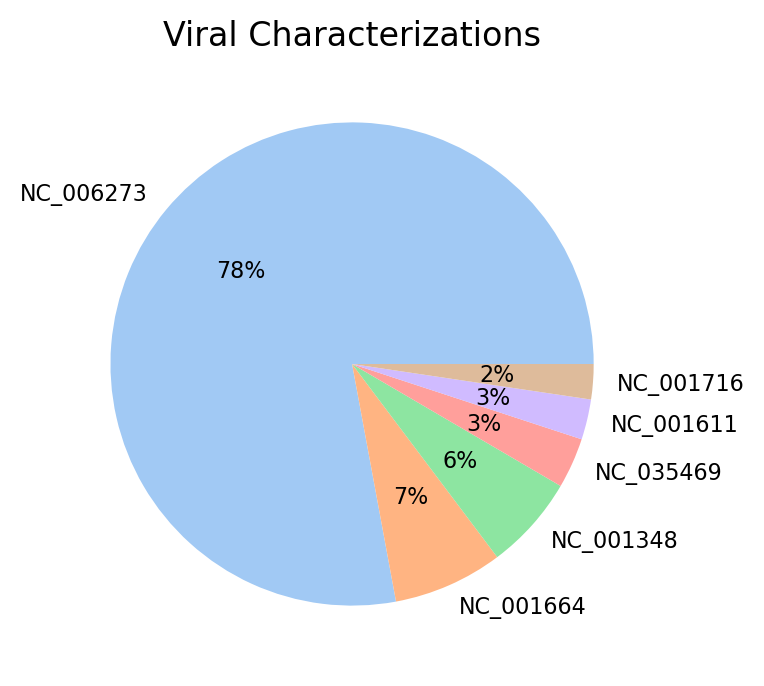

In [3]:
fig = plt.figure(dpi=200)

threshold_abundance = 1.0
selected_counts = viral_count_df.loc[viral_count_df["rel_abundance"] >= threshold_abundance]

# gathering data
labels = selected_counts["accession"]
scores = selected_counts["counts"] 

# generate a pie chart
colors = sns.color_palette('pastel')[0:10]

#create pie chart
plot = plt.pie(scores, labels=labels, colors=colors, autopct='%.0f%%', textprops={"fontsize": 8})
plt.title("Viral Characterizations")
plt.savefig("../results/viral_characterizations_piechart.png")
plt.show()


selected_counts.sample()

In [4]:
# Creating a label table that shoes the name of the virus with the associated the plot above
viral_taxa = ncbi_virus_data[["Representative", "family", "genus"]]
viral_taxa.columns = ["accession", "family", "genus"]
identified_virus_df = viral_taxa.merge(selected_counts, on="accession")
identified_virus_df = identified_virus_df.sort_values(by="rel_abundance", ascending=False)
identified_virus_df = identified_virus_df.set_index("accession")

# saving table as an image 
dfi.export(identified_virus_df, "../results/identified_virus_table.png")

identified_virus_df


objc[18212]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5c7eb948) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/102.0.5005.115/Libraries/libGLESv2.dylib (0x1105c7290). One of the two will be used. Which one is undefined.
[0616/015427.618467:INFO:headless_shell.cc(660)] Written to file /var/folders/88/kxtrpbsj7mg68w7mlprrsbvr0000gn/T/tmp4p04nq86/temp.png.


,family,genus,counts,rel_abundance
accession,,,,
NC_006273,Herpesviridae,Cytomegalovirus,1591,68.58
NC_001664,Herpesviridae,Roseolovirus,150,6.47
NC_001348,Herpesviridae,Varicellovirus,129,5.56
NC_035469,Poxviridae,Centapoxvirus,69,2.97
NC_001611,Poxviridae,Orthopoxvirus,55,2.37
NC_001716,Herpesviridae,Roseolovirus,48,2.07


## Profiling 

### geolocation profile 

In [5]:
found_viral_fam = identified_virus_df["family"].unique().tolist()
associated_bats_df = dbat_vir_df.loc[dbat_vir_df["Viral family"].isin(found_viral_fam)]

# removing any duplicates
group = associated_bats_df.groupby("From Bat")

list_dfs = []
for name, df in group:
    new_df = df.drop_duplicates(subset=["Viral family", "From Bat"])
    list_dfs.append(new_df)

associated_bats_df = pd.concat(list_dfs)
associated_bats_df["Sampling country"].unique()


# grouping by country and condensing data 
country_group = associated_bats_df.groupby("Sampling country")
bat_country_data = []
for name, df in country_group:
    
    if "congo" in name.lower():
        name = "Congo [Republic]"
    elif "united states of america" in name.lower():
        name = "United States"
    
    all_bats_str = " ".join(df["From Bat"].tolist())
    counts = len(df["From Bat"].tolist())
    viral_fam = ", ".join(df["Viral family"].unique().tolist())
    result = [name, viral_fam, all_bats_str, counts]

    bat_country_data.append(result)

# constructing dataframe
all_bats_country_df = pd.DataFrame(data=bat_country_data, columns=["country", "viral_fam", "all_bats", "bat_counts"])
all_bats_country_df = all_bats_country_df.sort_values(by="bat_counts", ascending=False)

# augmenting all identified bats with location data
alpha_iso_codes = iso_codes_df[["iso_alpha", "alpha_iso3"]]
all_bats_country_df = all_bats_country_df.merge(geolocations_df, on="country")
all_bats_country_df = all_bats_country_df.merge(alpha_iso_codes, on="iso_alpha")
all_bats_country_df.to_csv("../results/other_bats_country.csv", index=False)

# profile
all_bats_country_df

,country,viral_fam,all_bats,bat_counts,iso_alpha,alpha_iso3
0,Spain,Herpesviridae,Eptesicus isabellinus Hypsugo savii Myotis alc...,18,ES,ESP
1,China,"Herpesviridae, Poxviridae",Cynopterus sphinx Hipposideros larvatus Hippos...,9,CN,CHN
2,Peru,Herpesviridae,Artibeus lituratus Desmodus rotundus Diphylla ...,8,PE,PER
3,Uruguay,Herpesviridae,Eptesicus diminutus Eptesicus furinalis Moloss...,7,UY,URY
4,French Guiana,Herpesviridae,Anoura geoffroyi Carollia perspicillata Diaemu...,7,GF,GUF
5,Germany,Herpesviridae,Eptesicus serotinus Myotis nattereri Nyctalus ...,6,DE,DEU
6,United States,"Herpesviridae, Poxviridae",Eptesicus fuscus Eptesicus fuscus Myotis velifer,3,US,USA
7,South Africa,Herpesviridae,Miniopterus natalensis Neoromicia capensis Neo...,3,ZA,ZAF
8,Brazil,Herpesviridae,Artibeus planirostris Lonchophylla thomasi,2,BR,BRA
9,Congo [Republic],Herpesviridae,Pipistrellus nanulus Triaenops persicus,2,CG,COG


### Constructing a geo-plot map

In [6]:
# color="continent"
fig = px.scatter_geo(all_bats_country_df, locations="alpha_iso3" , color="bat_counts",
                     title="Identified Bat's Viral Family strains and Location",
                     hover_name="country", size="bat_counts",
                     projection="natural earth", hover_data=[all_bats_country_df["country"], all_bats_country_df["viral_fam"]])

fig.update_layout(height=1000, margin={"r":1,"t":100,"l":30,"b":0}, font=dict(size=25))

fig.show()

# saving as interactive plot
fig.write_html("../results/interactive_geo_plot.html")

# saving original plot
with open("../results/geo_plot.png", "wb") as outfile:
    img_bytes = fig.to_image(format="png", engine="kaleido")
    outfile.write(img_bytes)



### Associated diseases profile
Here is a table figures of the associated diseases with the found viral strains in the meta-genome sample

In [7]:
ident_viral_acc = identified_virus_df.index.tolist()
viral_info = ncbi_virus_data.loc[ncbi_virus_data["Representative"].isin(ident_viral_acc)]
viral_info.columns = ["accession"] + viral_info.columns.values.tolist()[1:]

# merging relative counts and relative abundance 
viral_counts_df = identified_virus_df.reset_index()[["accession", "rel_abundance"]]
viral_summary_df = viral_info.merge(viral_counts_df, on="accession").sort_values("rel_abundance", ascending=False)
viral_summary_df.columns = ['accession', 'host', 'disease_doc', 'segment_name', 'family', 'genus', 'taxon_id', 'rel_abundance']

# profile 
viral_summary_df


,accession,host,disease_doc,segment_name,family,genus,taxon_id,rel_abundance
4,NC_006273,human,Human herpesvirus 5,segment,Herpesviridae,Cytomegalovirus,10359,68.58
2,NC_001664,human,Human herpesvirus 6A,segment,Herpesviridae,Roseolovirus,32603,6.47
0,NC_001348,human,Human alphaherpesvirus 3,segment,Herpesviridae,Varicellovirus,10335,5.56
5,NC_035469,human,NY_014 poxvirus,segment,Poxviridae,Centapoxvirus,2025360,2.97
1,NC_001611,human,Variola virus,segment,Poxviridae,Orthopoxvirus,10255,2.37
3,NC_001716,human,Human herpesvirus 7,segment,Herpesviridae,Roseolovirus,10372,2.07


### Generate interaction profile
Creating a profile that shows the protein protein interactions that occurs with these viruses

In [8]:
# loading curated string_db data
ppi_df = vloader.load_human_ppi()

# then filter the ppi data with the taxon id found in the viral_summary df
found_virus_taxon_id = viral_summary_df["taxon_id"].unique().tolist()
ppi_df = ppi_df.loc[ppi_df["species_2"].isin(found_virus_taxon_id)]

# profile (NOTE: not all viruses wil have documented networks)
ppi_df

,species_1,protein_1,species_2,protein_2,score,annotation
0,9606,ENSP00000000233,10335,NP04_VZVD,437,Varicella-zoster virus (strain Dumas)
1,9606,ENSP00000000233,10255,F11_VAR67,188,Variola virus (isolate Human/India/Ind3/1967)
2,9606,ENSP00000000233,10335,GM_VZVD,336,Varicella-zoster virus (strain Dumas)
3,9606,ENSP00000000233,32603,GM_HHV6U,336,Human herpesvirus 6A (strain Uganda-1102)
4,9606,ENSP00000000233,10359,GM_HCMVM,336,Human cytomegalovirus (strain Merlin)
...,...,...,...,...,...,...
19048,9606,ENSP00000473166,10335,GB_VZVD,227,Varicella-zoster virus (strain Dumas)
19049,9606,ENSP00000473172,10359,UL27_HCMVM,435,Human cytomegalovirus (strain Merlin)
19050,9606,ENSP00000473243,32603,GB_HHV6U,227,Human herpesvirus 6A (strain Uganda-1102)
19051,9606,ENSP00000473243,10335,GB_VZVD,227,Varicella-zoster virus (strain Dumas)


### Generate a network plot
This will output interactions profiles in SIF format. This can be uploaded to network visualization programs like 
cytoscape

In [9]:
save_interaction_profiles(ppi_df)

In [10]:
from pathlib import Path

In [12]:
html_file = Path.cwd() / "./results/geo_plot.html"
html_file.as_uri()

'file:///Users/erikserrano/Development/prelim/prelim3/VSeek/analysis/../results/geo_plot.html'